In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Add, Conv2D, Flatten, BatchNormalization
from tensorflow.keras.models import Model
# import torch
# import tensorflow_probability as tfp
import gymnasium as gym
from collections import deque
import random
# from skimage.color import rgb2gray
# from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from datetime import datetime, timedelta
# import threading
# from queue import Queue
# import heapq
import cv2
# import math
import os
from send_email import send_email
from dotenv import load_dotenv
import pickle
load_dotenv()

True

In [22]:
NUM_FRAMES = 4
FRAME_WIDTH = 84
FRAME_HEIGHT = 64
DUELING_DQN = False
NUM_ACTIONS = 3
ACTIONS = [0, 2, 3]
GAME = "Breakout-v4"
SEED = 42

In [23]:
inputs = Input(shape=(FRAME_HEIGHT, FRAME_WIDTH, NUM_FRAMES))

x = Conv2D(32, 8, strides=4, activation='relu')(inputs)
x = Conv2D(64, 4, strides=2, activation='relu')(x)
x = Conv2D(64, 3, strides=1, activation='relu')(x)

x = Flatten()(x)

x = Dense(512, activation='relu')(x)
q_values = Dense(NUM_ACTIONS)(x)

model = Model(inputs=inputs, outputs=q_values)

In [24]:
def preprocess_state(state):
    start = time.time()
    try:
        state.shape
    except:
        state = state[0]
        pass
    processed_observe = cv2.cvtColor(state[17:,:], cv2.COLOR_RGB2GRAY)
    _, processed_observe = cv2.threshold(processed_observe, 0, 128, cv2.THRESH_BINARY)
    processed_observe = cv2.resize(processed_observe, (FRAME_WIDTH, FRAME_HEIGHT), interpolation=cv2.INTER_NEAREST)
    return processed_observe, time.time() - start

In [25]:
env = gym.make(GAME)
env.seed(SEED)
state = env.reset()
frame_buffer = deque(maxlen=NUM_FRAMES)
env.step(1)
for _ in range(NUM_FRAMES):
    processed_state, proc_time = preprocess_state(state)
    frame_buffer.append(processed_state)
state = np.stack(frame_buffer, axis=-1)

1/1 [==============================] - 0s 135ms/step


2023-11-29 13:02:26.641517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


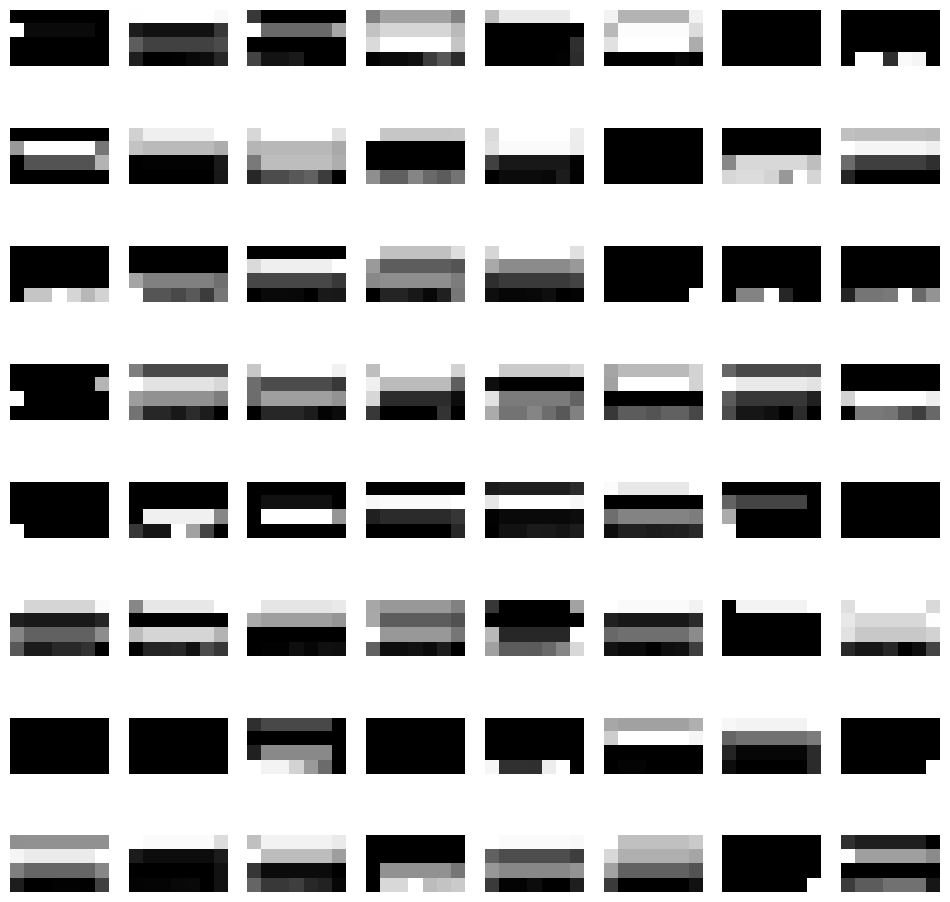

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Create a model to output the activation from the last convolutional layer
last_conv_layer = [layer for layer in model.layers if 'conv' in layer.name][-1]
activation_model = Model(inputs=model.input, outputs=last_conv_layer.output)

# Get the activation
activation = activation_model.predict(np.expand_dims(state, axis=0))

# Function to plot the feature maps
def display_feature_maps(activation, num_columns=8):
    num_features = activation.shape[-1]
    size = activation.shape[1]
    num_rows = num_features // num_columns
    
    fig = plt.figure(figsize=(num_columns * 1.5, num_rows * 1.5))

    for i in range(num_features):
        ax = fig.add_subplot(num_rows, num_columns, i + 1)
        ax.imshow(activation[0, :, :, i], cmap='gray')
        ax.axis('off')

# Display the feature maps
display_feature_maps(activation)